# stock data를 활용한 종가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 데이터 로드 및 종목 코드 기반 주식 데이터 로드

In [2]:
stock_list = pd.read_csv('dongkeun_ICT/stock_final/Stock_List.csv')

In [3]:
import FinanceDataReader as fdr # 가격 확인을 위하여 라이브러리 로드

In [4]:
#  종목코드 형태 균일화
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x :str(x).zfill(6)) # 파이썬 문자열에서 6개를 0으로 채우는 함수, 4자리 글자는 2개의 0이 추가된다.
# stock_list.head()

In [5]:
print(len(stock_list))

376


In [7]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     376 non-null    object
 1   종목코드    376 non-null    object
 2   상장시장    376 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


In [8]:
# 학습 대상 날짜 설정 및 기타 정보 파악
start_date = '20210104'
end_date = '20210903'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime("%V")
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq="B"),columns = ['Date'])

print(f'WEEKDAY of "start_date": {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date": 0
NUM of WEEKS to "end_date" : 35
HOW MANY "Business_days" : (175, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [9]:
# 지정한 날짜에 해당하는 주식 데이터를 종목코드와 라이브러리를 사용하여 로드
test_code = stock_list.loc[0,'종목코드']
test = fdr.DataReader(test_code,start = start_date, end = end_date).reset_index()
test.tail()

,Date,Open,High,Low,Close,Volume,Change
164,2021-08-30,75400,75500,74200,74600,12686999,0.004038
165,2021-08-31,74900,76700,74300,76700,24630370,0.028150
166,2021-09-01,76700,77100,75900,76800,16114775,0.001304
167,2021-09-02,76800,76800,75700,76000,15347486,-0.010417
168,2021-09-03,76400,76700,76000,76600,12096419,0.007895


### data scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Open','High','Low','Close','Volume','Change']
sc = scaler.fit(test[scale_cols])
df_scaled = sc.transform(test[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
scale_cols2 = ['Close']
sc2 = scaler2.fit(test[scale_cols2])
df_scaled_2 = sc2.transform(test[scale_cols2])
df_scaled_2 = pd.DataFrame(df_scaled_2)
df_scaled_2.columns = scale_cols2

In [12]:
df_scaled['Date']=test['Date']
df_scaled['Close'] = df_scaled_2['Close']

### 상관관계 분석

<AxesSubplot:>

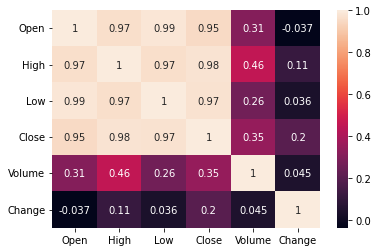

In [13]:
import seaborn as sns
sns.heatmap(df_scaled.corr(),annot=True)

In [14]:
print(len(test))

169


#### 데이터 시각화

In [15]:
# plt.figure(figsize = (16,9))
# sns.lineplot(y=test.loc[:,'Close'], x=test.loc[:,'Date'])
# plt.xlabel('time')
# plt.ylabel('price')
# plt.tight_layout()
# plt.show()

### pivot table 생성

In [16]:
test2 = pd.merge(Business_days, df_scaled, how='outer')
test2['weekday'] = test2.Date.apply(lambda x : x.weekday())
test2['weeknum'] = test2.Date.apply(lambda x : x.strftime('%V'))
test2.Close = test2.Close.ffill()
# test2 = pd.pivot_table(data = test2, values = ['Close','High','Low','Open'], columns = 'weekday', index = 'weeknum')
test2 = pd.pivot_table(data = test2, values = ['Close','High'], columns = 'weekday', index = 'weeknum')
test2.head()

Close                                              High            \
weekday         0         1         2         3         4         0         1   
weeknum                                                                         
01       0.562842  0.612022  0.519126  0.557377  0.879781  0.458515  0.436681   
02       1.000000  0.978142  0.928962  0.928962  0.836066  1.000000  0.764192   
03       0.672131  0.781421  0.792350  0.841530  0.770492  0.585153  0.615721   
04       0.912568  0.765027  0.704918  0.601093  0.508197  0.698690  0.668122   
05       0.562842  0.639344  0.650273  0.535519  0.590164  0.414847  0.545852   

                                       
weekday         2         3         4  
weeknum                                
01       0.462882  0.449782  0.703057  
02       0.755459  0.703057  0.781659  
03       0.659389  0.641921  0.689956  
04       0.602620  0.510917  0.484716  
05       0.502183  0.432314  0.441048

In [17]:
# test3 = pd.merge(Business_days, test, how='outer')
# test3['weekday'] = test3.Date.apply(lambda x : x.weekday())
# test3['weeknum'] = test3.Date.apply(lambda x : x.strftime('%V'))
# test3.Close = test3.Close.ffill()
# test3 = pd.pivot_table(data = test3, values = ['Close','High','Low'], columns = 'weekday', index = 'weeknum')
# test3.head()

In [18]:
test2.isna().sum()

       weekday
Close  0          0
       1          0
       2          0
       3          0
       4          0
High   0          2
       1          0
       2          2
       3          1
       4          1
dtype: int64

In [19]:
test2[:].describe()

Close                                                   High  \
weekday          0          1          2          3          4          0   
count    35.000000  35.000000  35.000000  35.000000  35.000000  33.000000   
mean      0.486339   0.500546   0.480562   0.474005   0.468696   0.380839   
std       0.189476   0.174387   0.167238   0.177631   0.184645   0.171785   
min       0.032787   0.081967   0.065574   0.021858   0.000000   0.004367   
25%       0.387978   0.404372   0.393443   0.387978   0.401639   0.292576   
50%       0.502732   0.497268   0.475410   0.491803   0.486339   0.371179   
75%       0.568306   0.603825   0.549180   0.554645   0.546448   0.445415   
max       1.000000   0.978142   0.928962   0.928962   0.879781   1.000000   

                                                     
weekday          1          2          3          4  
count    35.000000  33.000000  34.000000  34.000000  
mean      0.378915   0.370253   0.357180   0.358335  
std       0.150110   0.146743   0.139696   0.165747  
min       0.052402   0.030568   0.021834   0.000000  
25%       0.301310   0.292576   0.272926   0.280568  
50%       0.379913   0.375546   0.371179   0.358079  
75%       0.451965   0.441048   0.430131   0.418122  
max       0.764192   0.755459   0.703057   0.781659

In [20]:
test2[:]['High'][0].fillna(test2[:]['High'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
test2[:]['High'][2].fillna(test2[:]['High'][2].median(),inplace=True)
test2[:]['High'][3].fillna(test2[:]['High'][3].median(),inplace=True)
test2[:]['High'][4].fillna(test2[:]['High'][4].median(),inplace=True)

# test2[:]['Low'][0].fillna(test2[:]['Low'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# test2[:]['Low'][2].fillna(test2[:]['Low'][2].median(),inplace=True)
# test2[:]['Low'][3].fillna(test2[:]['Low'][3].median(),inplace=True)
# test2[:]['Low'][4].fillna(test2[:]['Low'][4].median(),inplace=True)

# test2[:]['Open'][0].fillna(test2[:]['Open'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# test2[:]['Open'][2].fillna(test2[:]['Open'][2].median(),inplace=True)
# test2[:]['Open'][3].fillna(test2[:]['Open'][3].median(),inplace=True)
# test2[:]['Open'][4].fillna(test2[:]['Open'][4].median(),inplace=True)

In [21]:
test2.isna().sum()

       weekday
Close  0          0
       1          0
       2          0
       3          0
       4          0
High   0          0
       1          0
       2          0
       3          0
       4          0
dtype: int64

In [22]:
# test2.isna()

### 모델 학습 테스트

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from tqdm import tqdm

In [24]:
model = Ridge(alpha=0.1)
x = test2.iloc[0:-2].to_numpy() # 0 to -2까지의 데이터로 학습을 하여서

y = test2.iloc[1:-1]['Close'].to_numpy() # 1 to -1까지의 데이터르 예측하는 과정을 수행
# 우리의 예측 대상은 월,화,수,목,금 5개의 feature이다.
y_0 = y[:,0] # 월요일
y_1 = y[:,1] # 화요일
y_2 = y[:,2] # 수요일
y_3 = y[:,3] # 목요일
y_4 = y[:,4] # 금요일

y_values = [y_0, y_1, y_2, y_3, y_4]

print(x.shape)
print(y_0.shape)
##################################
x_public = test2.iloc[-2].to_numpy()

predicitions = []
for y_value in y_values:
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0)) # 차원 추가
    predicitions.append(prediction[0])
    
print('-'*10)
print(predicitions)

y_public = test2.iloc[-1]['Close'].values

from sklearn.metrics import mean_squared_log_error
print(mean_squared_log_error(predicitions, y_public))

#0.0016648133440614176

(33, 10)
(33,)
----------
[0.1600377297721985, 0.14291596086569766, 0.12744181633095178, 0.12065791520975765, 0.10875106947656138]
0.004823611831291022


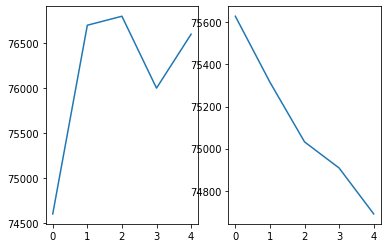

In [25]:
plt.subplot(1,2,1)
plt.plot(sc2.inverse_transform(y_public.reshape(-1,1)))
plt.subplot(1,2,2)
plt.plot(sc2.inverse_transform(np.array(predicitions).reshape(-1,1)))

In [26]:
X_train = x.reshape(x.shape[0],5,2)
X_train.shape

(33, 5, 2)

In [27]:
y_train = np.array(y_values)
y_train = y_train.reshape(y_train.shape[1],y_train.shape[0])

In [28]:
X_test = test2.iloc[-2].to_numpy()
X_test = X_test.reshape(1,5,2)

### RNN 테스트

In [29]:
def simple_rnn_model(X_train, y_train, X_test):
    """
    create single layer rnn model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense, SimpleRNN 
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences = True))
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(5)) # The time step of the output 
    
    my_rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
    
    # fit the RNN model 
    my_rnn_model.fit(X_train,y_train, epochs = 150, batch_size = 320, verbose = 0) 
    
    # Finalizing predictions 
    rnn_predictions = my_rnn_model.predict(X_test)
    
    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)

In [30]:
print(sc2.inverse_transform(rnn_predictions))

[[76763.9  82799.51 71351.9  76373.57 80680.79]]


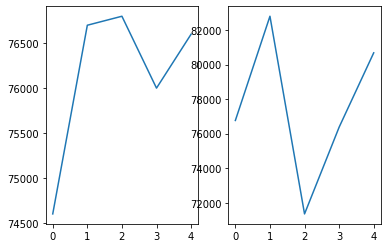

In [31]:
plt.subplot(1,2,1)
plt.plot(sc2.inverse_transform(y_public.reshape(-1,1)))
plt.subplot(1,2,2)
plt.plot(sc2.inverse_transform(rnn_predictions[0].reshape(-1,1)))

### LSTM 테스트

In [32]:
def LSTM_model(X_train, y_train, X_test):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],2), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=5))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.001, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 80, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    #LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test)

In [33]:
print(sc2.inverse_transform(LSTM_prediction))

[[75243.33 75167.4  75124.84 76058.86 75324.74]]


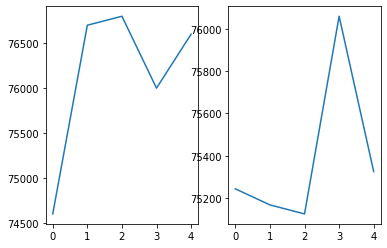

In [34]:
plt.subplot(1,2,1)
plt.plot(sc2.inverse_transform(y_public.reshape(-1,1)))
plt.subplot(1,2,2)
plt.plot(sc2.inverse_transform(LSTM_prediction[0].reshape(-1,1)))

## 전체 모델링

In [35]:
sample_name = 'dongkeun_ICT/stock_final/sample_submission_week3.csv'
sample_submission = pd.read_csv(sample_name)

In [ ]:
# model = Ridge(alpha=0.1)
for code in tqdm(stock_list['종목코드'].values):
    
    # data load
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    
    # scaling
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scale_cols = ['Open','High','Low','Close','Volume','Change']
    sc = scaler.fit(data[scale_cols])
    df_scaled = sc.transform(data[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    
    scaler2 = MinMaxScaler()
    scale_cols2 = ['Close']
    sc2 = scaler2.fit(data[scale_cols2])
    df_scaled_2 = sc2.transform(data[scale_cols2])
    df_scaled_2 = pd.DataFrame(df_scaled_2)
    df_scaled_2.columns = scale_cols2
    
    df_scaled['Date']=data['Date']
    df_scaled['Close'] = df_scaled_2['Close']
    
    # make pivot table
    data = pd.merge(Business_days, df_scaled, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
    data.Close = data.Close.ffill()
    data = pd.pivot_table(data = data, values = ['Close','High'], columns = 'weekday', index = 'weeknum')
    
    # nan value check
    if data.isna().sum().sum()>0:
        for i in range(5):
            data[:]['High'][i].fillna(data[:]['High'][i].median(),inplace=True) # inplace=True로 결측치 치환 반영
            #data[:]['Low'][i].fillna(data[:]['Low'][i].median(),inplace=True)
            data[:]['Close'][i].fillna(data[:]['Close'][i],inplace=True)
            #data[:]['Open'][i].fillna(data[:]['Open'][i],inplace=True)
              
    x = data.iloc[0:-2].to_numpy() # 2021년 1월 04일 ~ 2021년 8월 13일까지의 데이터로
    y = data.iloc[1:-1]['Close'].to_numpy() # 2021년 1월 11일 ~ 2021년 8월 20일까지의 데이터를 학습한다.
    y_0 = y[:,0]
    y_1 = y[:,1]
    y_2 = y[:,2]
    y_3 = y[:,3]
    y_4 = y[:,4]

    y_values = [y_0, y_1, y_2, y_3, y_4]
    #x_public = data.iloc[-2].to_numpy() # 2021년 8월 23일부터 8월 27일까지의 데이터를 예측할 것이다.
    
#     predictions = []
#     for y_value in y_values :
#         model.fit(x,y_value)
#         prediction = model.predict(np.expand_dims(x_public,0))
#         prediction = sc2.inverse_transform(prediction.reshape(-1,1))
#         predictions.append(prediction[0])
    
    # train LSTM
    X_train = x.reshape(x.shape[0],5,2)
    X_train.shape
    
    y_train = np.array(y_values)
    y_train = y_train.reshape(y_train.shape[1],y_train.shape[0])
    
    X_test = test2.iloc[-2].to_numpy()
    X_test = X_test.reshape(1,5,2)
    
    my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test)
    LSTM_prediction = sc2.inverse_transform(LSTM_prediction[0].reshape(-1,1))
    #print(LSTM_prediction.reshape(1,-1))
    predictions = []
    for data in LSTM_prediction:
        predictions.append(data)
#     print(predictions)
#     print(type(predictions[0]))
    
    sample_submission.loc[:,code] = predictions * 2
sample_submission.isna().sum().sum()

 48%|████▊     | 182/376 [22:33<41:12, 12.74s/it]  

In [ ]:
# MSE = Mean Square Error
# 오차 = 실제값 - 예측값에서
# 오차를 제곱하여 합한 것! square error
# 이 것을 데이터 개수로 나눈 것이 mean sqaure error

# 이 것을 주로 회귀분석에서 cost function으로 사용한다.

In [ ]:
sample_submission.columns

In [ ]:
columns = list(sample_submission.columns[1:])

In [ ]:
columns = ['Day'] + [str(x).zfill(6) for x in columns]

In [ ]:
sample_submission.columns = columns

In [ ]:
sample_submission.to_csv('BASELINE_Linear_Week3.csv',index=False)

In [ ]:
sample_submission